The United Nations World Food Program (WFP) supplies food assistance to around 100 million people in 80 countries each year.
Transporting food in a global transportation network is a challenging undertaking.
In this notebook, we will build an optimization model to set up a food supply chain based on real data from WFP.
The optimization model is motivated by the case studies in Syria by [Peters et al. (2021)](https://pubsonline.informs.org/doi/epdf/10.1287/ijoo.2019.0047), [Peters et al. (2022)](https://pubsonline.informs.org/doi/abs/10.1287/inte.2021.1097) and the [Zero Hunger Lab](https://www.tilburguniversity.edu/research/institutes-and-research-groups/zero-hunger-lab).

The idea is to transport food from cities identified as "suppliers" to beneficiary cities in Syria.
The quantity of food arriving at beneficiary cities must be sufficient enough to satisfy basic nutritional needs of the people there.
On the other hand, the procurement and transportation of food comes at a cost, and therefore must be done efficiently.
In this notebook, we will learn how to set up an optimization problem to achieve a cost-efficient food supply chain.

<!-- ![alt text](image/figure_syria.png) -->

<!-- |<img src="image/figure_syria.png" width="1000" align="center">|
|:--:|
| <b>Image Credits: [Peters et al. (2016). The Nutritious Supply Chain: Optimizing Humanitarian Food Aid. NFORMS Journal on Optimization.](https://pubsonline.informs.org/doi/10.1287/ijoo.2019.0047) </b>|  -->

In [5]:
from IPython.display import Image
print('Food supply chain in Syria:')
Image('figure_syria.png')

Food supply chain in Syria:


<!-- **Goal**:  -->

## Prepare the inputs

We need three types of data files. First, we will construct a transportation network that consists of supplier cities, transit hubs and beneficiary camps. Second, we will obtain information on the nutritional composition of different food types and the nutritional needs of an average person. Third, we will load information on the costs of procuring different food types from the supplier cities using historical data on procurement costs.

The following packages are needed to process and visualize the data.

In [6]:
# %pip install gurobipy networkx pydot seaborn
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import seaborn as sns
import datetime

### Create the transportation network

We will now create the transportation network stored as a **directed graph** data structure. Every node in the graph corresponds to a city in the network, and a direct edge corresponds to a transportation link.

First, load the data on the types of cities and the number of beneficiaries in each camp.

29
There are 15 cities in total. 11 are suppliers and 7 are beneficiary camps. 3 cities serve as both.
Number of people in each beneficiary camp:


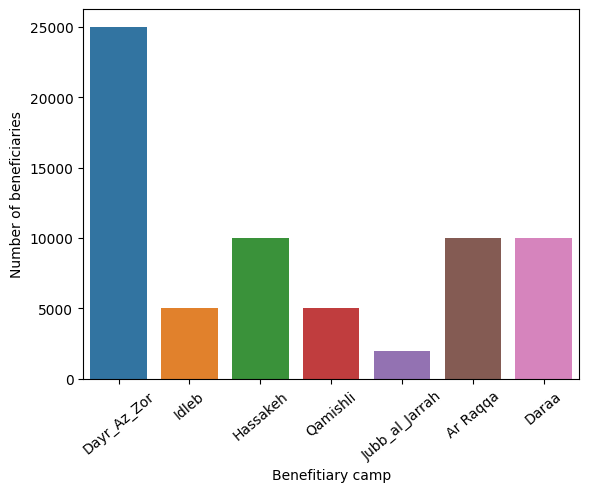

In [7]:
node_types = pd.read_csv('node_types.csv')

print(len(node_types))
N = set(node_types['Name'])
N_S = set(s[:-2] for s in N if s[-2:] == ' S') # suppliers
N_TS = set(s[:-3] for s in N if s[-2:] == 'TS') # transit hubs
N_B = set(s[:-2] for s in N if s[-1] == 'D') # beneficiary camps
N = N_S.union(N_TS,N_B)  # set of all cities
print("There are %i cities in total. %i are suppliers and %i are beneficiary camps. %i cities serve as both."%(len(N),len(N_S),len(N_B),len(N_S.intersection(N_B))))
demand = {i: node_types.set_index('Name').stack().to_dict()[i+' D','Demand'] for i in N_B}
print("Number of people in each beneficiary camp:")

bar = sns.barplot(x=list(demand.keys()), y=[demand[k] for k in demand])
bar.set_xticklabels(bar.get_xticklabels(), rotation=40);
bar.set(xlabel='Benefitiary camp', ylabel='Number of beneficiaries');
plt.show()

Next, load data on the transportation links (i.e., directed edges) in the transportation network along with the associated travel costs. Store and visualize the data using the networkx graph datastructure.  

<ipython-input-8-6e36946ddd6d>:10: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(G, pos = nx.nx_pydot.graphviz_layout(G),node_color=color_map, node_size=900, linewidths=.25, width=1, font_size=25, font_weight='bold', with_labels=True, arrowsize=50, verticalalignment='top', horizontalalignment='right')
<ipython-input-8-6e36946ddd6d>:11: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  nx.draw_networkx_edge_labels(G, pos = nx.nx_pydot.graphviz_layout(G), edge_labels = t,  font_size=20)


Green node: Only a supplier, Red node: Only a beneficiary, Blue node: Both a supplier and a beneficiary. 
The transportation cost for each edge is also shown.


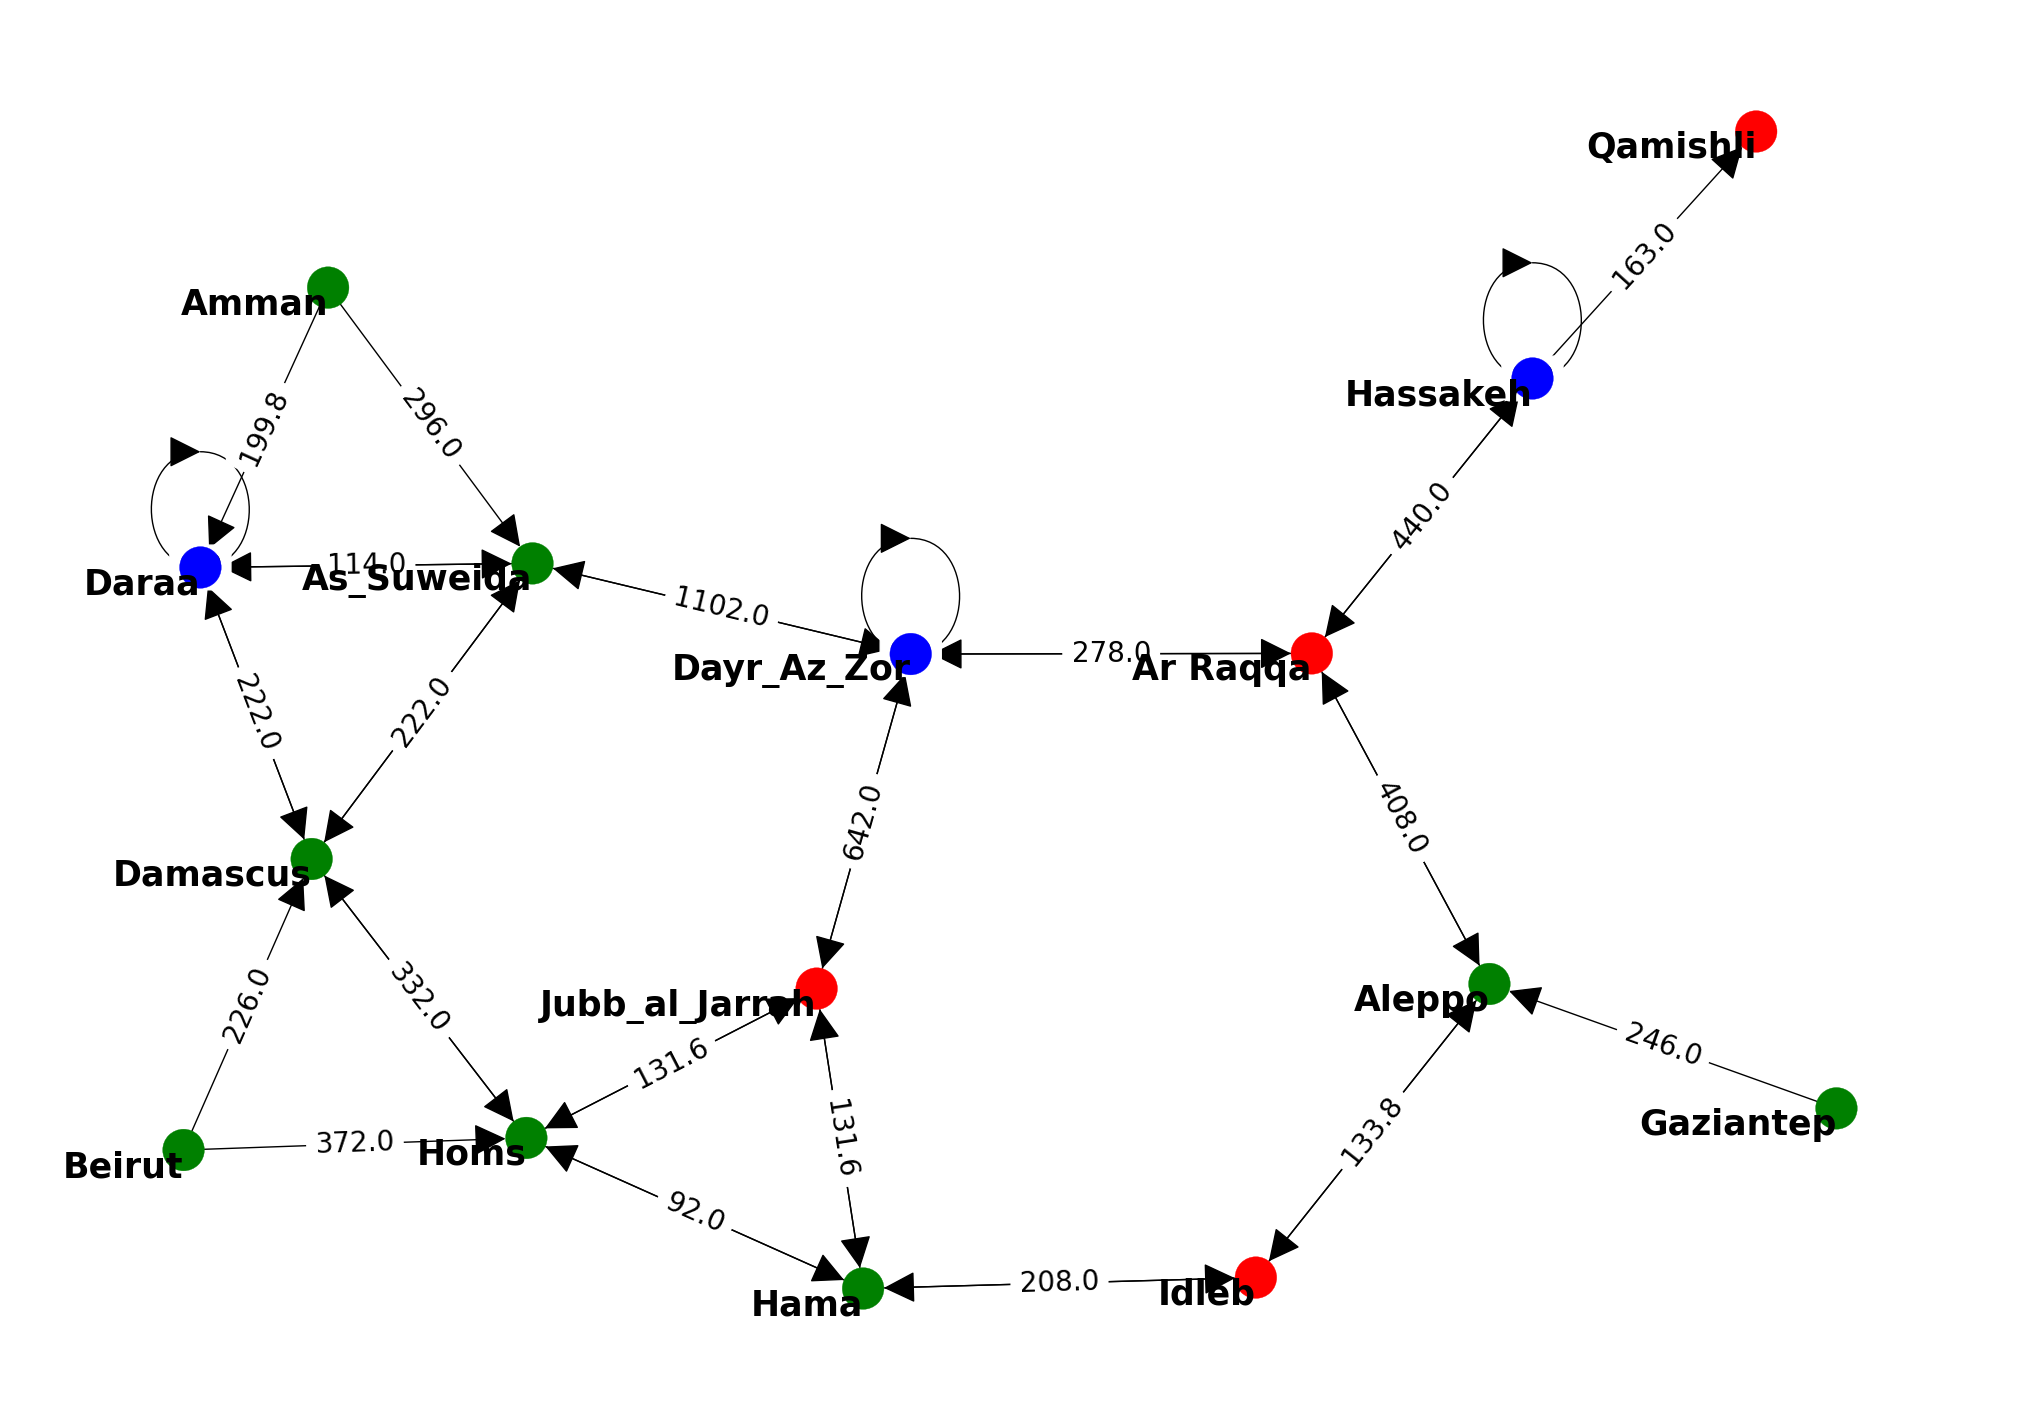

In [8]:
edge_costs = pd.read_csv('edge_costs.csv')
t = edge_costs.set_index(['A','B']).tCost.to_dict() # travel cost for each link
edges = list(t.keys())  # directed edges

G = nx.DiGraph() # create an empty directed graph
G.add_edges_from(edges) # add edges to the graph; this step automatically creates the nodes as well
plt.figure(figsize=(20,14))
color_map = ['green' if (i in N_S and i not in N_B) else 'red' if (i in N_B and i not in N_S) else 'blue' if (i in N_B and i in N_S) else 'lightblue' for i in G.nodes()]

nx.draw(G, pos = nx.nx_pydot.graphviz_layout(G),node_color=color_map, node_size=900, linewidths=.25, width=1, font_size=25, font_weight='bold', with_labels=True, arrowsize=50, verticalalignment='top', horizontalalignment='right')
nx.draw_networkx_edge_labels(G, pos = nx.nx_pydot.graphviz_layout(G), edge_labels = t,  font_size=20)
print("Green node: Only a supplier, Red node: Only a beneficiary, Blue node: Both a supplier and a beneficiary. \nThe transportation cost for each edge is also shown.")
plt.show()

### Nutritional needs and availability

Next, we will gather nutritional information. An average person has specific minimum limits on several nutrient types. Load this data.

In [9]:
nutrient_requirements = pd.read_csv('nutrient_requirements.csv', index_col=False)
U = nutrient_requirements.columns.values.tolist() # Set of all nutrients
U.remove('Type')
m = {u: nutrient_requirements.to_dict()[u][0] for u in U}  # dicionary containing minimum nutritional requirement per person
pd.DataFrame(m, index=[0])

Energy(kcal)  Protein(g)  Fat(g)  Calcium(mg)  Iron(mg)  VitaminA(ug)  \
0          2100        52.5   89.25         1100        22           500   

   ThiamineB1(mg)  RiboflavinB2(mg)  NicacinB3(mg)  Folate(ug)  VitaminC(mg)  
0             0.9               1.4             12         160            28

In order to supply the appropriate food type for each person, we need to know the nutritional content of each food type. Load this data.

Below we will see the nutritional content for five out of the 24 food types.

In [10]:
food_nutrition = pd.read_csv('food_nutrition.csv', index_col=False)
F = set(food_nutrition['Food']) # Set of all food types
v = food_nutrition.set_index('Food').stack().to_dict() # dicionary containing nutrional content in each food type
df_nutrition = pd.Series(v).reset_index() # creating a new dataframe to display the data
df_nutrition.columns = ['Food', 'Nutrient', 'Amount']
df_nutrition.pivot_table(index=['Food'], columns='Nutrient', values='Amount', fill_value=0).reset_index().rename_axis(None, axis=1).head(5)

Food  Calcium(mg)  Energy(kcal)  Fat(g)  Folate(ug)  \
0                  Beans          143           335     1.2         180   
1                 Bulgur           23           350     1.5          38   
2                 Cheese          630           355    28.0           0   
3              Chickpeas          130           335     1.4         100   
4  Corn-soya blend (CSB)          513           380     6.0           0   

   Iron(mg)  NicacinB3(mg)  Protein(g)  RiboflavinB2(mg)  ThiamineB1(mg)  \
0       8.2            2.1        20.0              0.22            0.50   
1       7.8            5.5        11.0              0.10            0.30   
2       0.2            0.2        22.5              0.45            0.03   
3       5.2            3.0        22.0              0.19            0.60   
4      18.5            6.8        18.0              0.50            0.65   

   VitaminA(ug)  VitaminC(mg)  
0             0             0  
1             0             0  
2           120             0  
3             0             0  
4           500            40

### Procurement costs

Procuring food from suppliers comes at a cost. This cost depends on the food type and the supplier city.

Historical procurement costs are available for each month from January 2017 through October 2021. For our model, we will use the mean historical food costs. Here, the costs are listed in USD.

In [11]:
df_food_costs = pd.read_csv('food_costs.csv')
p = df_food_costs.set_index(['supplier','food'])['Mean'].to_dict()

Finally, the data from 'food_costs.csv' only contains a subset of all food types and supplier cities. For the rest of the food types and suppliers, we set their procurement costs to be the international average prices derived from the 'food_internationalprice.csv' as shown below. Due to this limitation in data availability, we assume that the prices are constant for these food types and cities.

Aggregating both the datasets and the regressor fit, we can estimate procurement costs for a given month and year.
Below are the estimated costs for January 2022.

In [12]:
international_food_price = pd.read_csv('food_internationalprice.csv').set_index('Food')['InternationalPrice'].to_dict()

p.update({(i,f): international_food_price[f] for f in F for i in N_S if (i,f) not in p})
pd.Series(p).unstack()

Beans   Bulgur   Cheese  Chickpeas  Corn-soya blend (CSB)  \
Aleppo       2781.60  1140.78  4856.08    1545.27                 1300.0   
Amman        1000.00   800.00  2800.00    1000.00                 1300.0   
As_Suweida   2931.64  1369.06  4667.97    1926.07                 1300.0   
Beirut       1000.00   800.00  2800.00    1000.00                 1300.0   
Damascus     3360.25  1213.61  4401.05    1955.07                 1300.0   
Daraa        3498.93  1308.43  3949.85    1442.84                 1300.0   
Dayr_Az_Zor  3569.61  1699.02  5250.71    2389.77                 1300.0   
Gaziantep    1000.00   800.00  2800.00    1000.00                 1300.0   
Hama         3420.83  1312.39  4577.32    2020.41                 1300.0   
Hassakeh     2675.23  1256.44  4034.07    1704.37                 1300.0   
Homs         3331.51  1309.08  4332.71    1963.68                 1300.0   

               Dates  Dried skim milk (enriched) (DSM)      Fish  Lentils  \
Aleppo       3507.66                            2000.0   8031.74  1682.86   
Amman        2500.00                            2000.0   4500.00  1000.00   
As_Suweida   3908.45                            2000.0   9487.86  1917.50   
Beirut       2500.00                            2000.0   4500.00  1000.00   
Damascus     3758.75                            2000.0  10200.98  1759.06   
Daraa        3624.71                            2000.0   9702.98  1721.23   
Dayr_Az_Zor  5463.01                            2000.0  13952.11  1978.11   
Gaziantep    2500.00                            2000.0   4500.00  1000.00   
Hama         3850.50                            2000.0  11499.20  1796.77   
Hassakeh     2874.19                            2000.0   9401.05  1471.91   
Homs         3649.14                            2000.0  10965.20  1759.30   

             Maize  ...     Rice  Sorghum/millet  Soya-fortified bulgur wheat  \
Aleppo       600.0  ...  1719.78           650.0                       1100.0   
Amman        600.0  ...   800.00           650.0                       1100.0   
As_Suweida   600.0  ...  1485.76           650.0                       1100.0   
Beirut       600.0  ...   800.00           650.0                       1100.0   
Damascus     600.0  ...  1640.30           650.0                       1100.0   
Daraa        600.0  ...  2054.62           650.0                       1100.0   
Dayr_Az_Zor  600.0  ...  2032.78           650.0                       1100.0   
Gaziantep    600.0  ...   800.00           650.0                       1100.0   
Hama         600.0  ...  1768.67           650.0                       1100.0   
Hassakeh     600.0  ...  1665.43           650.0                       1100.0   
Homs         600.0  ...  1050.25           650.0                       1100.0   

             Soya-fortified maize meal  Soya-fortified sorghum grits  \
Aleppo                           900.0                        1300.0   
Amman                            900.0                        1300.0   
As_Suweida                       900.0                        1300.0   
Beirut                           900.0                        1300.0   
Damascus                         900.0                        1300.0   
Daraa                            900.0                        1300.0   
Dayr_Az_Zor                      900.0                        1300.0   
Gaziantep                        900.0                        1300.0   
Hama                             900.0                        1300.0   
Hassakeh                         900.0                        1300.0   
Homs                             900.0                        1300.0   

             Soya-fortified wheat flour    Sugar     WSB  Wheat  Wheatflour  
Aleppo                            900.0  1330.82  1500.0  550.0     1048.02  
Amman                             900.0  1100.00  1500.0  550.0      700.00  
As_Suweida                        900.0  1360.39  1500.0  550.0     1194.98  
Beirut                     

In the next section, we will design an optimization model to establish a cost-effective supply chain.

## Optimizing a food supply chain

We now create an optimization model to optimize the food supply chain. First, we define the input parameters of the model. Then, we describe the three parts of an optimization model. First, the **decision variables** control the decisions made in this model, such as the amount of food transported through the network. Second, the **objective function** is a function that is being optimized. In our model, we minimize the total cost of procuring and transporting the food. Third, the **constraints** ensure that the decision variables are assigned meaningful values. For example, the amount of food transported should be sufficient enough to meet the dietary requirements of the beneficiaries.

Let us now define some input parameters and notations used for creating the model. The subscripts $i$ and $j$ are used to denote cities, $f$ for each food type, and $u$ for each nutrient.

### Input Parameters
- $N_S$: set of all supplier cities,
- $N_B$: set of all beneficiary cities,
- $N = N_S \cup N_B$: set of all cities,
- $b_j$: number of beneficiaries in beneficiary city $j$,
- $E$: set of all edges defining the transportation links,
- $U$: set of all nutrients,
- $m_u$: minimum requirement for nutrient $u$ per person,
- $F$: set of all food types,
- $v_{f,u}$: amount of nutrient $u$ in food type $f$,
- $p_{f,i}$: procurement cost per unit of food $f$ in supplier city $i$,
- $t_{(i,j)}$: transportation cost per unit of food in edge $(i,j)$.

The following code loads the Gurobi python package and initiates the optimization model.

In [14]:
%pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 39.9 MB/s eta 0:00:00


In [15]:
import gurobipy as gp
from gurobipy import GRB
model = gp.Model("foodsupply")

Restricted license - for non-production use only - expires 2024-10-28


### Decision variables

Let us now define the decision variables. In our model, we want to track the amount of food to be purchased from the suppliers and the amount of food each person receives in the beneficiary cities. To ensure that the food is efficiently transported in the network, we also track the amount of food flowing in each link. The following notations are used to model these decision variables.

$r_{f,j}$: the ration size per person for food type $f$ in beneficiary city $j$,

$s_{f,i}$: the amount of food type $f$ purchased in supplier city $i$,

$x_{f,i,j}$: the amount of food type $f$ transported on the link $(i,j)$.

We will now add the variables to the Gurobi model.

In [16]:
r = model.addVars(F, N_B, name="r") # amount of each food type per person in each beneficiary location

P = {(f,i): 10000000 for f in F for i in N_S} # we set a large upper limit on the amount of food purchased
s = model.addVars(F, N_S, name="s", lb=0, ub=P) # amount of each food type purchased from each supply location

x = model.addVars(F, edges, name="x") # amount of each food type flowing in each edge

print("This model has",len(x)+len(r)+len(s),"decision variables in total.")

model.update()

This model has 1320 decision variables in total.


### Set the objective

Next, we will define the objective function: We want to minimize the total cost incurred in procuring the food from supplier cities and in transporting the food through the network. The model assumes that there are no other costs.

Using the defined decision variables, the cost objective can be written as follows.

\begin{align}
\textrm{minimize} &  \sum_{\textrm{food } f}  \sum_{\textrm{supplier } i} s_{f,i} * p_{f,i} + \sum_{\textrm{food } f} \sum_{\textrm{edge } (i,j)} x_{f,i,j} * t_{(i,j)}  &
\end{align}

There are two ways to build the objective: using element-wise summation or by simply taking the vector product as shown in the commented code.

In [17]:
objective = gp.quicksum(s[f,i]*p[i,f] for f in F for i in N_S) # procurement cost
objective += gp.quicksum(x[f,i,j]*t[i,j] for f in F for (i,j) in edges)   # transport cost
model.setObjective(objective,sense=GRB.MINIMIZE)

# model.setObjective(s.prod(ProcCost)+x.prod(t),sense=GRB.MINIMIZE)

### Add constraints to ensure nutritional requirements

We now introduce the constraints. The first constraint makes sure that the amount of food received by each person is enough to satisfy their minimum nutrition levels. This constraint can be mathematically expressed as follows for each beneficiary city $j$ and nutrient $u$.

\begin{align*}
m_u \leq \sum_{\textrm{food } f} v_{f,u} * r_{f,j} &\leq M_u
\end{align*}

The summation in the left hand side gives the per capita amount of nutrient $u$ across all the food types supplied to the beneficiary city $j$. The following code adds this constraint to the model.

In [18]:
M = {u: 2*m[u] for u in m} # we assume that the upper limit for each nutrient value is twice the lower limit

model.addConstrs((gp.quicksum(v[f,u]*r[f,j] for f in F) == [m[u], M[u]]) for u in U for j in N_B)
model.update()

### Add flow constraints to capture the flow of food from suppliers to beneficiaries


Next, we make sure that the flow variables correctly transport the food from supply cities to beneficiaries.

The model assumes that food "flows" the cities. Beneficiary camps "absorb" the required amount of food, while supply cities "release" foods that are purchased from them. In cities that act as both a beneficiary and a supplier, the net food flowing out of the city is whatever that remains after absorption.

To understand the flow through each city, we first construct *preceding* and *succeeding neighbors*. For each city $i$, the set of preceding neighbors denoted by $\delta^-(i)$ are the cities **from** where there is a directed edge **to $i$**. Similarly, succeeding neighbors denoted by $\delta^+(i)$ are the cities **to** which there is a directed edge **from $i$**. The following code finds these neighbors using networkx and shows the neighbors of Damascus as an example.

In [19]:
delta_minus = {i: set(G.predecessors(i)) for i in N}  # preceding neighbors of each city
delta_plus = {i: set(G.successors(i)) for i in N}  # forward neighbors of each city

print("Damascus can receive food from",delta_minus['Damascus'],"\nDamascus send food to",delta_plus['Damascus'])

Damascus can receive food from {'Homs', 'Daraa', 'As_Suweida', 'Beirut'} 
Damascus send food to {'Homs', 'Daraa', 'As_Suweida'}


Using these neighborhoods, we can control the amount of food flowing through the network. For each city $i$, the amount of food type $f$ flowing **into** $i$ is the sum of all the flows from its preceding neighbors, given by $\sum\limits_{j\ \in\ \delta^-(i)} x_{f,j,i}$. Similarly, the amount of food type $f$ flowing **out of** $i$ is the sum of all flows to its succeeding neighbors, given by $\sum\limits_{j\ \in\ \delta^+(i)} x_{f,i,j}$. Notice that the subscripts of $x$ capture the direction of flow out of $i$ versus into $i$ from its neighbor $j$.


The difference between these two quantities gives the **net flow into city $i$**. The following constraints are defined for each city $i$ and food type $f$.
If $i$ is **a beneficiary and not a supplier**, then
\begin{align*}
\sum_{\textrm{preceding neighbor } j\ \in\ \delta^-(i)} x_{f,j,i} - \sum_{\textrm{succeeding neighbor } i\ \in\ \delta^+(i)} x_{f,i,j} &= b_j*r_{f,i}
\end{align*}

Here, the right-hand side is the amount of food absorbed in the beneficiary camp.

If $i$ is **a supplier and not a beneficiary**, then
\begin{align*}
\sum_{\textrm{preceding neighbor } j\ \in\ \delta^-(i)} x_{f,j,i} - \sum_{\textrm{succeeding neighbor } i\ \in\ \delta^+(i)} x_{f,i,j} &= -s_{f,i}
\end{align*}

Here, the right-hand side is the amount of food procured from the supplier city. Notice that the negative sign indicates that a negative amount of food is flowing into the supplier, which is equivalent to saying that a positive amount of food is leaving the supplier.


If $i$ is **both a supplier and a beneficiary**, then
\begin{align*}
\sum_{\textrm{preceding neighbor } j\ \in\ \delta^-(i)} x_{f,j,i} - \sum_{\textrm{succeeding neighbor } i\ \in\ \delta^+(i)} x_{f,i,j} &=  b_j*r_{f,i}-s_{f,i}
\end{align*}

Here, the right-hand side is the net amount of food absorbed by the city.

<!-- \begin{equation}
\sum_{\textrm{preceding neighbor } j\ \in\ \delta^-(i)} x_{f,j,i} - \sum_{\textrm{succeeding neighbor } i\ \in\ \delta^+(i)} x_{f,i,j} =
\begin{cases}
  b_j*r_{f,i}, & \text{if}\ i \in N_B \backslash N_S \\
  -s_{f,i}, & \text{if}\ i \in N_S \backslash N_B \\
  b_j*r_{f,i}-s_{f,i}, & \text{if}\ i \in N_B \cap N_S
\end{cases}
\end{equation} -->

All three sets of constraints can be added to the Gurobi model with the following code.

In [20]:
for f in F:
    for i in N:
        if i in N_B and i not in N_S:
            model.addConstr((gp.quicksum(x[f,j,i] for j in delta_minus[i])-gp.quicksum(x[f,i,j] for j in delta_plus[i]) == demand[i]*r[f,i]))
        if i in N_S and i not in N_B:
            model.addConstr((gp.quicksum(x[f,j,i] for j in delta_minus[i])-gp.quicksum(x[f,i,j] for j in delta_plus[i]) == -s[f,i]))
        if i in N_S and i in N_B:
            model.addConstr((gp.quicksum(x[f,j,i] for j in delta_minus[i])-gp.quicksum(x[f,i,j] for j in delta_plus[i]) == demand[i]*r[f,i]-s[f,i]))
model.update()
# D+ = []

### Fire up the solver

We have added the decision variables, objective function, and constraints to the model.
The model is ready to be solved.

In [21]:
model.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 437 rows, 1397 columns and 3541 nonzeros
Model fingerprint: 0xb604c02b
Coefficient statistics:
  Matrix range     [3e-02, 2e+04]
  Objective range  [9e+01, 2e+04]
  Bounds range     [9e-01, 1e+07]
  RHS range        [2e+00, 4e+03]
Presolve removed 48 rows and 120 columns
Presolve time: 0.01s
Presolved: 389 rows, 1277 columns, 3445 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.456350e+03   0.000000e+00      0s
     875    4.0081239e+08   0.000000e+00   0.000000e+00      0s

Solved in 875 iterations and 0.08 seconds (0.02 work units)
Optimal objective  4.008123940e+08


## Visualize the optimal food supply

The optimizer has completed solving the optimization problem. The optimal total cost of procurement and transportation is:

In [22]:
print("$",round(model.ObjVal/10**6,2),"million")

$ 400.81 million


### Food flow networks

We now visualize the flow of food in the transportation network. To do that, we retrieve the optimal value of each variable using ".X", as shown below. This code displays the edges where there is a non-zero flow for each food type.

Optimal flow of Oil :


<ipython-input-23-bcb55361f53f>:8: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(graph, pos = nx.nx_pydot.graphviz_layout(G),node_size=100, width=1, linewidths=.25, font_size=14, font_weight='bold', with_labels=True,arrowsize=15, verticalalignment='bottom')


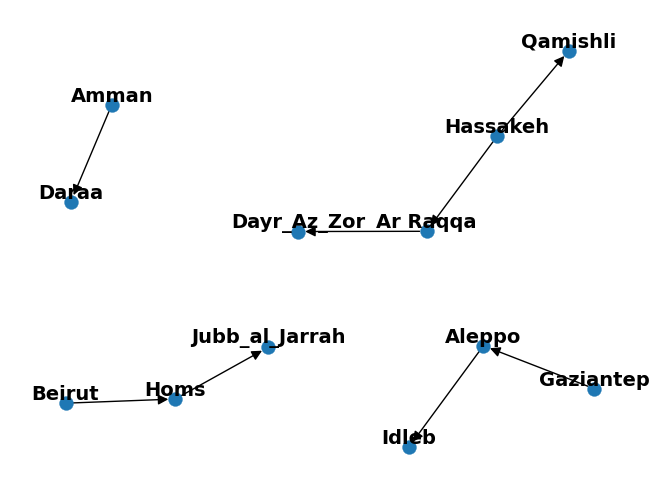

Optimal flow of Corn-soya blend (CSB) :


<ipython-input-23-bcb55361f53f>:8: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(graph, pos = nx.nx_pydot.graphviz_layout(G),node_size=100, width=1, linewidths=.25, font_size=14, font_weight='bold', with_labels=True,arrowsize=15, verticalalignment='bottom')


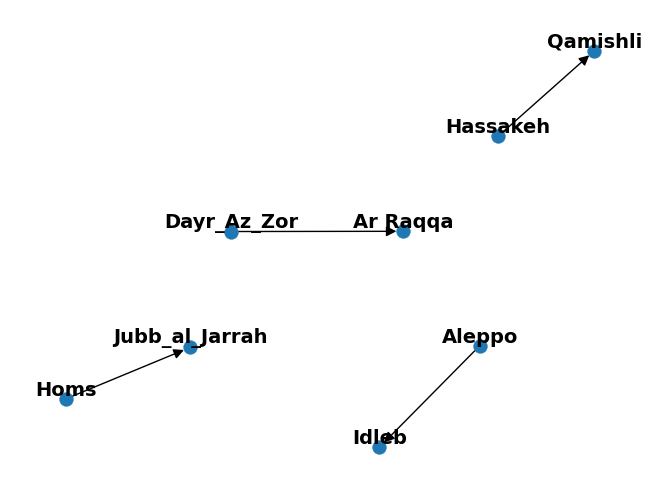

Optimal flow of Wheat :


<ipython-input-23-bcb55361f53f>:8: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(graph, pos = nx.nx_pydot.graphviz_layout(G),node_size=100, width=1, linewidths=.25, font_size=14, font_weight='bold', with_labels=True,arrowsize=15, verticalalignment='bottom')


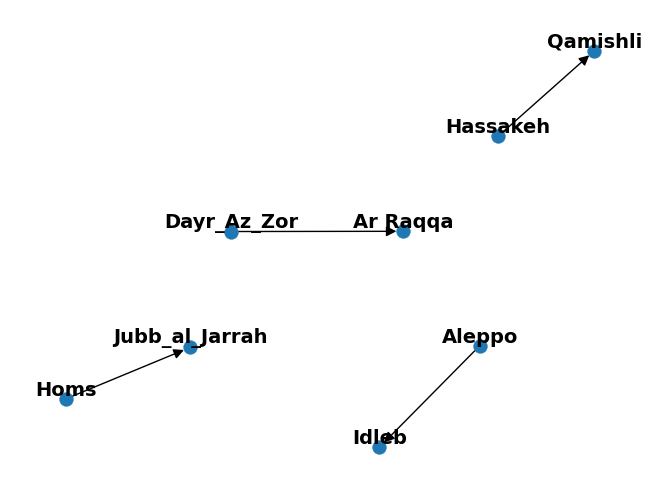

Optimal flow of Maize meal :


<ipython-input-23-bcb55361f53f>:8: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(graph, pos = nx.nx_pydot.graphviz_layout(G),node_size=100, width=1, linewidths=.25, font_size=14, font_weight='bold', with_labels=True,arrowsize=15, verticalalignment='bottom')


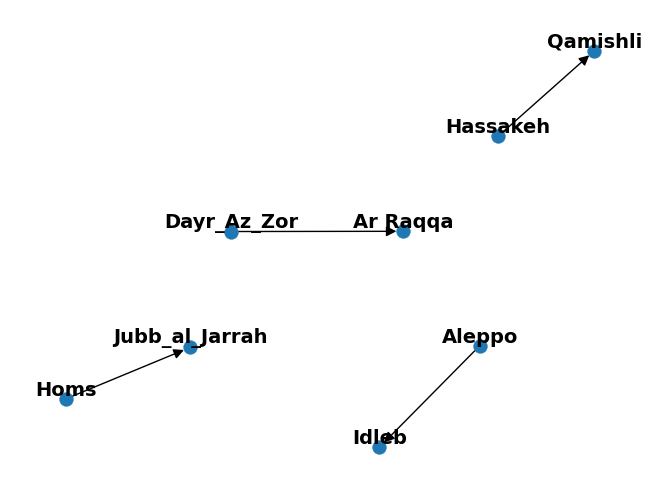

Optimal flow of Milk :


<ipython-input-23-bcb55361f53f>:8: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(graph, pos = nx.nx_pydot.graphviz_layout(G),node_size=100, width=1, linewidths=.25, font_size=14, font_weight='bold', with_labels=True,arrowsize=15, verticalalignment='bottom')


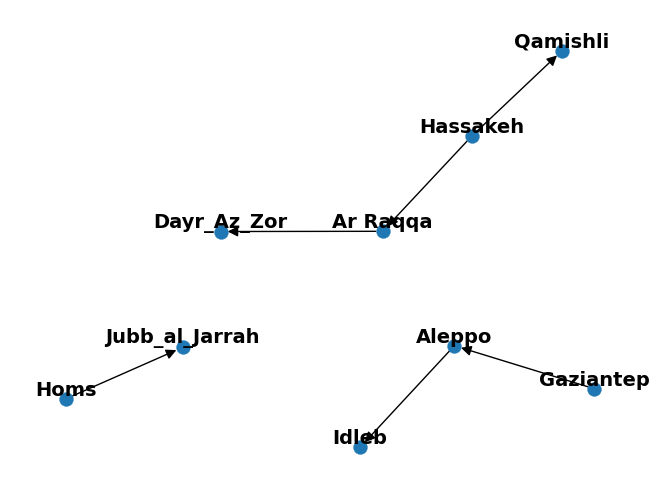

In [23]:
for f in F:
    flow_f = {(i,j): x[f,i,j].X for (i,j) in edges if x[f,i,j].X > 0} # retrieve the optimal variables values

    # plot the flow networks for each food type
    if flow_f != {}:
        graph = G.edge_subgraph(flow_f.keys())
        print("Optimal flow of",f,":")
        nx.draw(graph, pos = nx.nx_pydot.graphviz_layout(G),node_size=100, width=1, linewidths=.25, font_size=14, font_weight='bold', with_labels=True,arrowsize=15, verticalalignment='bottom')
        plt.show()

Next, we can visualize the amount of food received by each beneficiary using the following code.

Each of the 25000 beneficiaries in Dayr_Az_Zor receives:


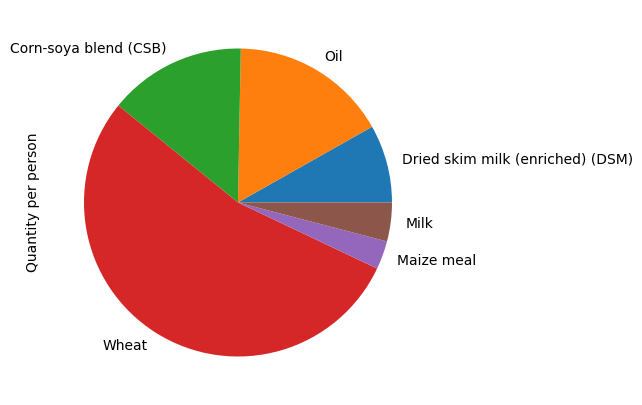

Each of the 5000 beneficiaries in Idleb receives:


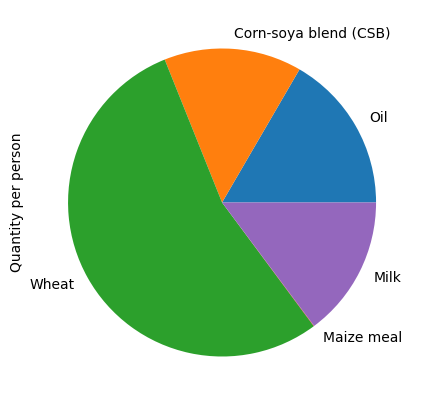

Each of the 10000 beneficiaries in Hassakeh receives:


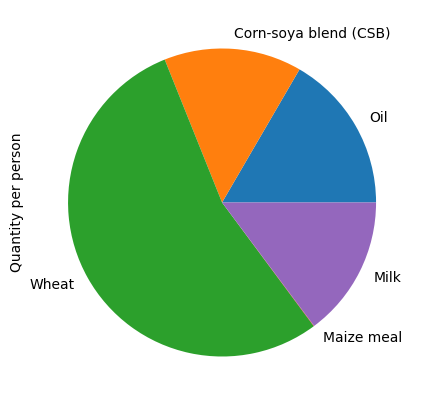

Each of the 5000 beneficiaries in Qamishli receives:


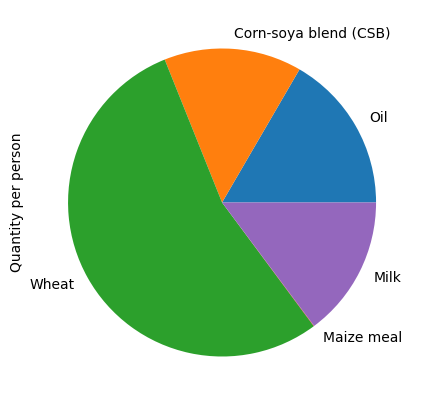

Each of the 2000 beneficiaries in Jubb_al_Jarrah receives:


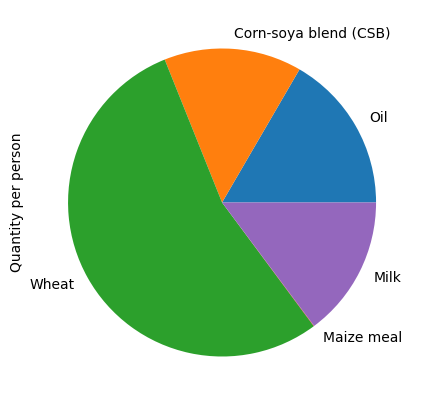

Each of the 10000 beneficiaries in Ar Raqqa receives:


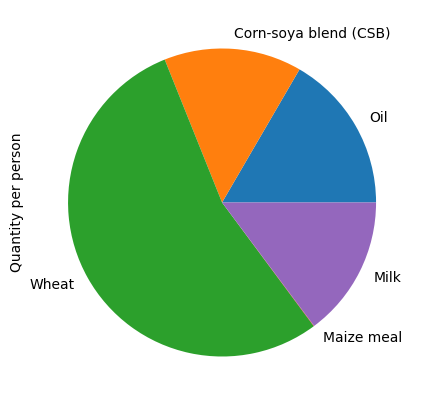

Each of the 10000 beneficiaries in Daraa receives:


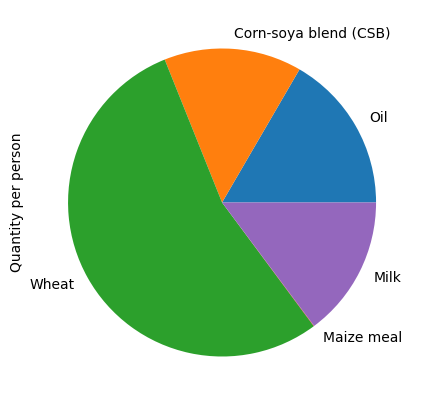

In [24]:
df_beneficiary = pd.DataFrame([[j,f,r[f,j].X] for j in N_B for f in F if r[f,j].X > 0],columns=['Beneficiary city', 'Food','Quantity per person'])

for i in N_B:
    df = df_beneficiary[df_beneficiary['Beneficiary city']==i].set_index('Food')
    print("Each of the %i beneficiaries in %s receives:"%(demand[i],i))
    plot = df.plot.pie(y='Quantity per person', figsize=(5, 5),legend=None)
    plt.show()

As a beneficiary, the food composition they receive depends on which city they are located in. Although, the overall nutrition meets the minimum nutritional requirements.

Next, we can also visualize the optimal amount of food procured from each supplier city.

Supplier city Amman supplies:


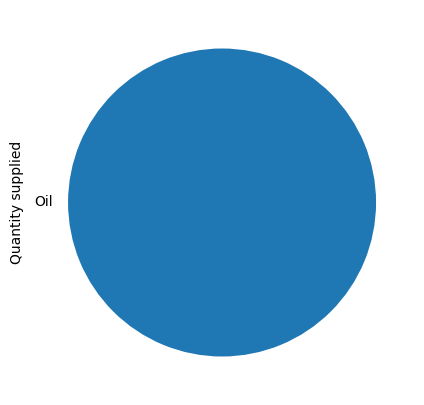

Supplier city Dayr_Az_Zor supplies:


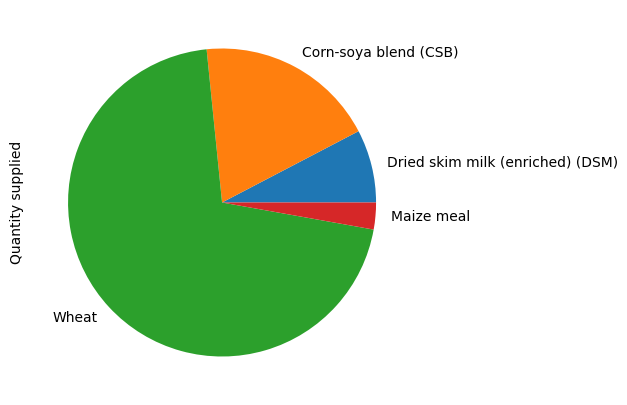

Supplier city Hassakeh supplies:


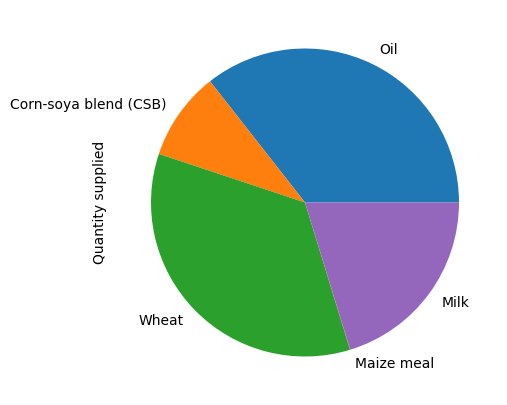

Supplier city Gaziantep supplies:


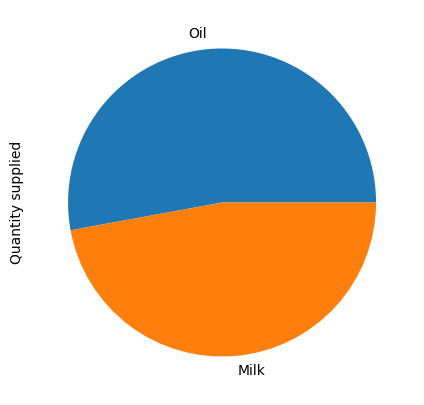

Supplier city Homs supplies:


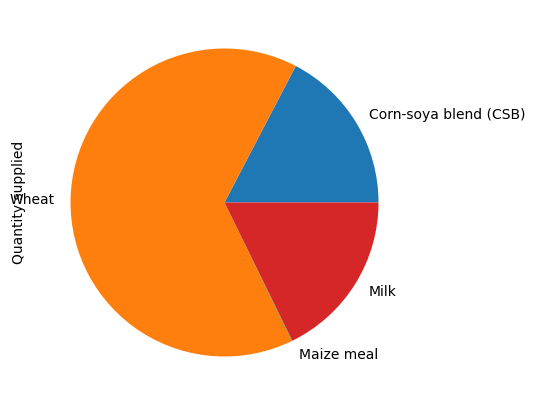

Supplier city Beirut supplies:


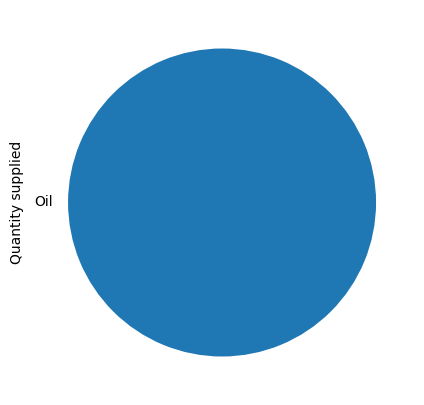

Supplier city Daraa supplies:


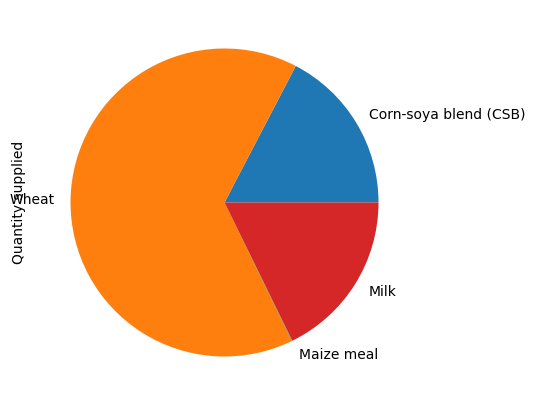

Supplier city Aleppo supplies:


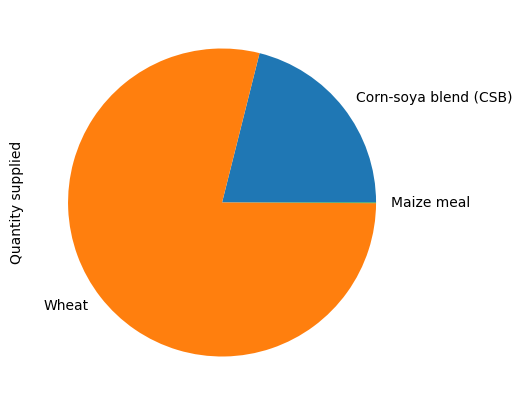

In [25]:
df_supply = pd.DataFrame([[i,f,round(s[f,i].X,2),p[i,f]] for i in N_S for f in F if s[f,i].X > 0],columns=['Supply city', 'Food','Quantity supplied','Procurement cost'])

for i in N_S:
    df = df_supply[df_supply['Supply city']==i].set_index('Food')
    if len(df)>0:
        print("Supplier city %s supplies:"%(i))
        plot = df.plot.pie(y='Quantity supplied', figsize=(5, 5),legend=None)
        plt.show()


This notebook demonstrates how to formulate an optimization model to set up a cost-efficient supply chain. In practice, there may be other considerations not captured in this model. For example, certain combinations of food types may be more favorable to create meaningful recipes. Or certain transportation links may have a limit on how much food can be transported through them. These considerations can also be modeled as additional constraints.